### Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random

#import any other library you need below this line

import PIL
import time

In [ ]:
# intall wandb
!pip install wandb --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 32.6 MB/s 
     |████████████████████████████████| 182 kB 68.6 MB/s 
     |████████████████████████████████| 166 kB 62.0 MB/s 
     |████████████████████████████████| 63 kB 410 kB/s 
     |████████████████████████████████| 166 kB 61.0 MB/s 
     |████████████████████████████████| 162 kB 63.4 MB/s 
     |████████████████████████████████| 162 kB 47.3 MB/s 
     |████████████████████████████████| 158 kB 56.9 MB/s 
     |████████████████████████████████| 157 kB 61.9 MB/s 
     |████████████████████████████████| 157 kB 64.1 MB/s 
     |████████████████████████████████| 157 kB 62.3 MB/s 
     |████████████████████████████████| 157 kB 63.1 MB/s 
     |████████████████████████████████| 157 kB 62.4 MB/s 
     |████████████████████████████████| 157 kB 53.9 MB/s 
     |████████████████████████████████| 157 kB 59.0 MB/s 
     |███████████████████████████

In [ ]:
import wandb

os.environ['WANDB_NOTEBOOK_NAME'] = 'some text here'
wandb.login()

True

### Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [ ]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace __MACOSX/._data? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Defining the Dataset Class

In [ ]:
class Cell_data(Dataset):
  def __init__(self, data_dir, size, train = 'True', train_test_split = 0.8, augment_data = True):
    ##########################inputs##################################
    #data_dir(string) - directory of the data#########################
    #size(int) - size of the images you want to use###################
    #train(boolean) - train data or test data#########################
    #train_test_split(float) - the portion of the data for training###
    #augment_data(boolean) - use data augmentation or not#############
    super(Cell_data, self).__init__()
    # todo
    #initialize the data class
    self.data_dir = data_dir
    self.img_dir = os.path.join(self.data_dir, "scans")
    self.size = size
    self.train = train
    self.augment_data = augment_data
    self.images = sorted(os.listdir(self.img_dir))

    split_point = int(len(self.images) * train_test_split)
    self.training = self.images[:split_point]
    self.testing = self.images[split_point:]


  def __getitem__(self, idx):
      # todo
      #load image and mask from index idx of your data
      if self.train:
        item = self.training[idx]
      else:
        item = self.testing[idx]

      img_path = os.path.join(self.data_dir, "scans", item)
      img = Image.open(img_path)
      img = img.resize((self.size, self.size))
      #img = img.thumbnail((self.size,self.size), Image.ANTIALIAS)
      
      label_path = os.path.join(self.data_dir, "labels", item)
      label = Image.open(label_path)
      label = label.resize((self.size, self.size))
      #label = label.thumbnail((self.size,self.size), Image.ANTIALIAS)
      
      #data augmentation part
      if self.augment_data:
        augment_mode = np.random.randint(0, 4)
        if augment_mode == 0:
          #todo 
          #flip image vertically
          img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
          label = label.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif augment_mode == 1:
          #todo
          #flip image horizontally
          img = img.transpose(PIL.Image.FLIP_TOP_BOTTOM)
          label = label.transpose(PIL.Image.FLIP_TOP_BOTTOM)
        elif augment_mode == 2:
          #todo
          #zoom image
          zoom_factor = 2

          h, w = img.size
          zh = int(np.round(h * zoom_factor))
          zw = int(np.round(w * zoom_factor))
          img = img.resize((zh, zw))
          label = label.resize((zh, zw))

          top = (zh - h) // 2
          left = (zw - w) // 2
          right = (zw + w) //2
          bottom = (zh + h) // 2

          img = img.crop((left, top, right, bottom))
          label = label.crop((left, top, right, bottom))
        else:
          #todo
          #rotate image
          max_angle = 15
          
          angle = np.random.randint(-max_angle, max_angle)
          img = img.rotate(angle)
          label = label.rotate(angle)

      #todo
      #return image and mask in tensors

      #converts a PIL Image or numpy.ndarray to a tensor of data type torch.float32 in range 0 and 1
      transform = transforms.Compose([transforms.ToTensor()])
      img = transform(img)

      # converts a PIL image to a tensor of data type torch.uint8 in the range between 0 and 255
      transform = transforms.Compose([transforms.PILToTensor()])
      label = transform(label)

      #normalization to improves the learning performance and the stability
      mean, std = img.mean([1, 2]), img.std([1, 2]) # calculate mean & std
      transform_norm = transforms.Compose([transforms.Normalize(mean, std)]) # define custom transform using calculated mean & std
      img = transform_norm(img) # normalize the image

      return img, label

      
  def __len__(self):
    if self.train:
      return len(self.training)
    else:
      return len(self.testing)


### Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. Combine the down and up path to get the final model

In [ ]:
class twoConvBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
      super(twoConvBlock, self).__init__()
      #todo
      #initialize the block
      self.layers = nn.Sequential(
          nn.Conv2d(in_channels = input_channel, out_channels = output_channel, kernel_size=3),
          nn.ReLU(),
          nn.Conv2d(in_channels = output_channel, out_channels = output_channel, kernel_size=3),
          nn.BatchNorm2d(output_channel),
          nn.ReLU())

  def forward(self, x):
    #todo
    #implement the forward path
    return self.layers(x)

class downStep(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(downStep, self).__init__()
    #todo
    #initialize the down path
    self.block = twoConvBlock(input_channel, output_channel)
    self.maxPlooling = nn.MaxPool2d(kernel_size = 2)

  def forward(self, x):
    #todo
    #implement the forward path
    x = self.block(x)
    out = self.maxPlooling(x)
    return out, x

class upStep(nn.Module):
  def __init__(self, input_channel):
    super(upStep, self).__init__()
    #todo
    #initialize the up path
    self.upSampling =  nn.ConvTranspose2d(in_channels=input_channel, out_channels=int(input_channel/2), kernel_size=2, stride=2)
    self.block = twoConvBlock(input_channel, int(input_channel/2))

  def forward(self, input, x):
    #todo
    #implement the forward path
    out = self.upSampling(input)
    B, C, H, W = out.size()
    
    crop = transforms.Compose([transforms.CenterCrop((H, W))])
    x = crop(x)

    out = torch.cat((x, out), dim=1)
    out = self.block(out)
    return out

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        #todo
        #initialize the complete model
        self.con1 = downStep(input_channel=1, output_channel=64)
        self.con2 = downStep(input_channel=64, output_channel=128)
        self.con3 = downStep(input_channel=128, output_channel=256)
        self.con4 = downStep(input_channel=256, output_channel=512)
        self.conv_block = twoConvBlock(input_channel=512, output_channel=1024)
        self.exp1 = upStep(input_channel=1024)
        self.exp2 = upStep(input_channel=512)
        self.exp3 = upStep(input_channel=256)
        self.exp4 = upStep(input_channel=128)
        self.last_conv = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)

    def forward(self, input):
        #todo
        #implement the forward path
        out, x1 = self.con1(input)
        out, x2 = self.con2(out)
        out, x3 = self.con3(out)
        out, x4 = self.con4(out)
        out = self.conv_block(out)
        out = self.exp1(input=out, x=x4)
        out = self.exp2(input=out, x=x3)
        out = self.exp3(input=out, x=x2)
        out = self.exp4(input=out, x=x1)
        out = self.last_conv(out)
        return out

### Training

In [ ]:
#Paramteres

#learning rate
lr = 1e-3
#number of training epochs
epoch_n = 15
#input image-mask size
image_size = 572
#root directory of project
root_dir = os.getcwd()
#training batch size
batch_size = 4
#use checkpoint model for training
load = False
#use GPU for training
gpu = True

In [ ]:
conf_dict = {
  "learning_rate": lr,
  "epochs": epoch_n,
  "batch_size": batch_size,
  "image_size": image_size
}

wandb.init(
    project="CMPT-732",
    config = conf_dict,
    name = f'lr{lr}-ep{epoch_n}-bs{batch_size}-im{image_size}')

In [ ]:
t1 = time.perf_counter()
# training/testing set loading
data_dir = os.path.join(root_dir, '/content/data/cells')

trainset = Cell_data(data_dir = data_dir, size = image_size, augment_data = False)
aug_trainset = Cell_data(data_dir = data_dir, size = image_size, augment_data = True) # data augmentation
trainset = trainset + aug_trainset
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False, augment_data = False)
testloader = DataLoader(testset, batch_size = batch_size)
print('trainset length (augmented): %d, testset length: %d' % (trainset.__len__(), testset.__len__()))

device = torch.device('cuda:0' if gpu else 'cpu')

model = UNet().to('cuda:0').to(device)

if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0005)
#optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.99, 0.999), weight_decay=0.0005) 

train_loss = [] # initialize a list to save training losses
test_loss = [] # initialize a list to save testing losses

model.train()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  for i, data in enumerate(trainloader):
    image, label = data

    image = image.to(device)
    label = label.long().to(device) # torch.Size([B, C, H, W])
    label = label.squeeze(1) # torch.Size([B, H, W]), since only batches of spatial targets supported (3D tensors) in "criterion(pred, label)"

    pred = model(image) # torch.Size([B, CLASS, H, W]) where CLASS is # of classes

    crop_x = (label.shape[1] - pred.shape[2]) // 2
    crop_y = (label.shape[2] - pred.shape[3]) // 2

    label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y] # to match size
    
    loss = criterion(pred, label)

    loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.

    optimizer.step() # updates the value of x using the gradient x.grad
    optimizer.zero_grad() # clears x.grad for every parameter x in the optimizer, otherwise you’ll accumulate the gradients from multiple passes

    epoch_loss += loss.item()

    #print('Batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / trainset.__len__()))
  train_loss.append(epoch_loss / trainset.__len__()) # save training loss for each epoch
  wandb.log({"epoch": e+1})
  wandb.log({"training loss": epoch_loss / trainset.__len__()}) # log training loss

  torch.save(model.state_dict(), 'checkpoint.pt')

  model.eval() # Sets model in evaluation (inference) mode Equivalent to model.train(False)

  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad(): # temporarily sets all of the requires_grad flags to false
    for i, data in enumerate(testloader):
      image, label = data

      image = image.to(device)
      label = label.long().to(device)
      label = label.squeeze(1) 

      pred = model(image)

      crop_x = (label.shape[1] - pred.shape[2]) // 2
      crop_y = (label.shape[2] - pred.shape[3]) // 2

      label = label[:, crop_x: label.shape[1] - crop_x, crop_y: label.shape[2] - crop_y]

      loss = criterion(pred, label)
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)

      total += label.shape[0] * label.shape[1] * label.shape[2]
      correct += (pred_labels == label).sum().item()

    test_loss.append(total_loss / testset.__len__()) # save testing loss for each epoch
    wandb.log({"testing loss": total_loss / testset.__len__()}) # log testing loss
    print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
    wandb.log({"testing accuracy": correct / total}) # log testing loss

    t2 = time.perf_counter()

trainset length (augmented): 60, testset length: 8
Epoch 1 / 15 --- Loss: 0.1411
Accuracy: 0.8384 ---- Loss: 0.0980
Epoch 2 / 15 --- Loss: 0.1191
Accuracy: 0.7985 ---- Loss: 0.1160
Epoch 3 / 15 --- Loss: 0.1171
Accuracy: 0.8505 ---- Loss: 0.0906
Epoch 4 / 15 --- Loss: 0.1093
Accuracy: 0.8370 ---- Loss: 0.1029
Epoch 5 / 15 --- Loss: 0.1179
Accuracy: 0.8358 ---- Loss: 0.1040
Epoch 6 / 15 --- Loss: 0.1174
Accuracy: 0.6922 ---- Loss: 0.1238
Epoch 7 / 15 --- Loss: 0.1126
Accuracy: 0.8555 ---- Loss: 0.0984
Epoch 8 / 15 --- Loss: 0.1070
Accuracy: 0.7320 ---- Loss: 0.1106
Epoch 9 / 15 --- Loss: 0.1061
Accuracy: 0.8642 ---- Loss: 0.0928
Epoch 10 / 15 --- Loss: 0.1068
Accuracy: 0.8695 ---- Loss: 0.0913
Epoch 11 / 15 --- Loss: 0.1112
Accuracy: 0.8746 ---- Loss: 0.0906
Epoch 12 / 15 --- Loss: 0.1026
Accuracy: 0.8544 ---- Loss: 0.1014
Epoch 13 / 15 --- Loss: 0.1108
Accuracy: 0.8682 ---- Loss: 0.0897
Epoch 14 / 15 --- Loss: 0.1086
Accuracy: 0.8610 ---- Loss: 0.1060
Epoch 15 / 15 --- Loss: 0.1133
Acc

In [ ]:
print('Time taken to train:',t2-t1, 'sec')

wandb.finish()

Time taken to train: 213.09315788700042 sec


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
testing accuracy,▇▅▇▇▇▁▇▃███▇█▇▇
testing loss,▃▆▁▄▄█▃▅▂▁▁▃▁▄▂
training loss,█▄▄▂▄▄▃▂▂▂▃▁▂▂▃
epoch,15
testing accuracy,0.85789
testing loss,0.09592
training loss,0.11329


### Testing and Visualization

In [ ]:
model.eval()

output_masks = []
output_labels = []

with torch.no_grad():
    for i in range(testset.__len__()):
        image, labels = testset.__getitem__(i) # image torch.Size([C, H, W]), labels torch.Size([C, H, W])

        input_image = image.unsqueeze(0).to(device) # image unsqueezed torch.Size([B, C, H, W]) since "pred = model(input_image)" expected 4D input
        pred = model(input_image) # pred torch.Size([B, CLASS, H, W])

        labels = labels.squeeze(0) # label squeezed torch.Size([H, W])
        output_mask = torch.max(pred, dim=1)[1].cpu().squeeze(0).numpy() # (H, W)

        crop_x = (labels.shape[0] - output_mask.shape[0]) // 2
        crop_y = (labels.shape[1] - output_mask.shape[1]) // 2
        labels = labels[crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].numpy()

        output_masks.append(output_mask)
        output_labels.append(labels)

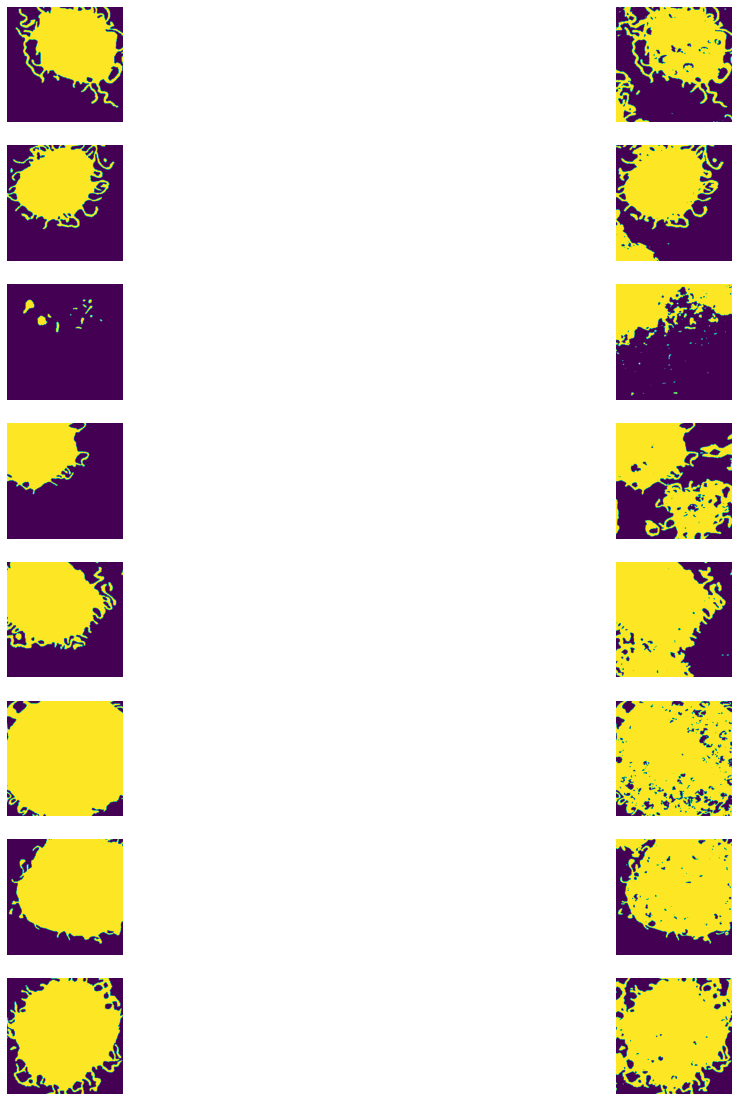

In [ ]:
fig, axes = plt.subplots(testset.__len__(), 2, figsize = (20, 20))

for i in range(testset.__len__()):
  axes[i, 0].imshow(output_labels[i])
  axes[i, 0].axis('off')
  axes[i, 1].imshow(output_masks[i])
  axes[i, 1].axis('off')

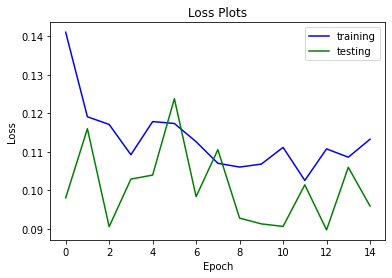

In [ ]:
fig, ax= plt.subplots()
epoch_losses = list(range(epoch_n))
ax.plot(epoch_losses, train_loss, label='training', color='b')
ax.plot(epoch_losses, test_loss, label='testing', color='g')
ax.set(xlabel='Epoch', ylabel='Loss',
       title='Loss Plots')

ax.legend()
fig.show()